In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

data_train = pd.read_csv("trainWithLabels.csv")
data_train = data_train[data_train.Label == 0]
data_test = pd.read_csv("testWithLabels.csv")
data_train = data_train.sample(20000)
test_labels = data_test.Label



C:\Users\Alex\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Alex\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
test_labels[test_labels == 1] = -1
test_labels[test_labels == 0] = 1

C:\Users\Alex\AppData\Local\Temp\ipykernel_12840\668489764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels[test_labels == 1] = -1
C:\Users\Alex\AppData\Local\Temp\ipykernel_12840\668489764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels[test_labels == 0] = 1


In [ ]:
data_train.drop(["srcip", "sport", "dstip", "dsport", "proto", "Label"], axis=1, inplace=True)
data_test.drop(["srcip", "sport", "dstip", "dsport", "proto", "Label",], axis=1, inplace=True)

In [ ]:
data_train.drop(["state", "service", "is_sm_ips_ports", "is_ftp_login", "Ltime"], axis=1, inplace=True)
data_test.drop(["state", "service", "is_sm_ips_ports", "is_ftp_login", "Ltime"], axis=1, inplace=True)

In [ ]:
data_train.drop(["attack_cat", "ct_flw_http_mthd", "ct_ftp_cmd"], axis=1, inplace=True)
data_test.drop(["attack_cat", "ct_flw_http_mthd", "ct_ftp_cmd"], axis=1, inplace=True)

In [ ]:
data_train.dropna(axis=0, inplace=True)
data_test.dropna(axis=0, inplace=True)

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(data_train)

data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.85)
pca.fit(data_train)
pca.n_components_

13

In [ ]:
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

# One Class SVM

In [ ]:
from sklearn.svm import OneClassSVM

X = data_train
a = data_test
clf = OneClassSVM(gamma='auto', nu=0.02).fit(X)
preds = clf.predict(a)

results = pd.DataFrame()
results["labels"] = test_labels
results["OneClassSVM_preds"] = preds

# Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.02).fit(X)
preds = clf.predict(a)
results["IsolationForest_preds"] = preds


# Elliptic Envelope

In [ ]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=0.0265, assume_centered=False).fit(X)
preds = clf.predict(a)
results["EllipticEnvelope_preds"] = preds

# Results

In [ ]:
from sklearn.metrics import f1_score

results.replace(to_replace=1, value="Benign", inplace=True)
results.replace(to_replace=-1, value="Malicious", inplace=True)

scoreOCSVM = f1_score(results.labels, results.OneClassSVM_preds, pos_label="Malicious")
print('OneClassSVM F1 Score: %.3f' % scoreOCSVM)

scoreIF = f1_score(results.labels, results.IsolationForest_preds, pos_label="Malicious")
print('Isolation Forest F1 Score: %.3f' % scoreIF)

scoreEE = f1_score(results.labels, results.EllipticEnvelope_preds, pos_label="Malicious")
print('Elliptic Envelope F1 Score: %.3f' % scoreEE)

OneClassSVM F1 Score: 0.840
Isolation Forest F1 Score: 0.332
Elliptic Envelope F1 Score: 0.930


Predicted One Class SVM  Benign  Malicious
Actual                                    
Benign                   759994      43743
Malicious                 26757     185525


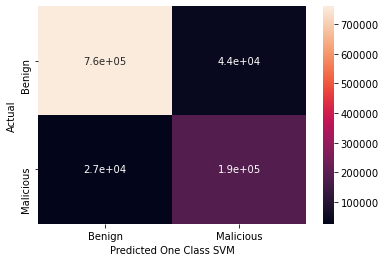

Predicted Isolation Forest  Benign  Malicious
Actual                                       
Benign                      786070      17667
Malicious                   166553      45729


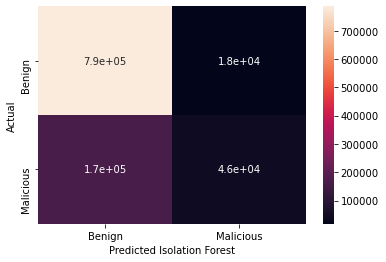

Predicted Elliptic Envelope  Benign  Malicious
Actual                                        
Benign                       771653      32084
Malicious                         6     212276


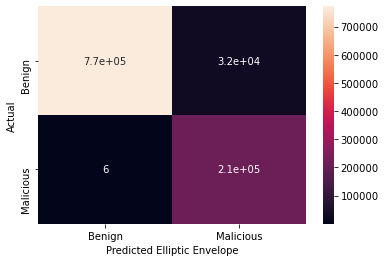

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt


confusion_matrix_OCSVM = pd.crosstab(results.labels, results.OneClassSVM_preds, rownames=['Actual'], colnames=['Predicted One Class SVM'])
confusion_matrix_IF = pd.crosstab(results.labels, results.IsolationForest_preds, rownames=['Actual'], colnames=['Predicted Isolation Forest'])
confusion_matrix_EE = pd.crosstab(results.labels, results.EllipticEnvelope_preds, rownames=['Actual'], colnames=['Predicted Elliptic Envelope'])

print(confusion_matrix_OCSVM)
sn.heatmap(confusion_matrix_OCSVM, annot=True)
plt.show()
print(confusion_matrix_IF)
sn.heatmap(confusion_matrix_IF, annot=True)
plt.show()
print(confusion_matrix_EE)
sn.heatmap(confusion_matrix_EE, annot=True)
plt.show()


In [ ]:
results.labels.value_counts()

Benign       803737
Malicious    212282
Name: labels, dtype: int64